In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import utils
from tqdm import tqdm, trange

In [2]:
data = pd.read_csv('data/train.csv')
data['epoch'] = pd.to_datetime(data['epoch']).astype(np.int64)

In [3]:
sat_id = 0
sat_data = data[data['sat_id'] == sat_id].reset_index(drop=0)

In [4]:
coord_cols = ['x', 'y', 'z']
speed_cols = ['Vx', 'Vy', 'Vz']
state_cols = coord_cols + speed_cols

In [5]:
G = 6.6743e-11 # gravity constant
M = 5.972e+24  # Earth mass

# coord = np.array([x, y, z])
# speed = np.array([Vx, Vy, Vz])
#sat_state = np.array([x, y, z, Vx, Vy, Vz])
def Earth_gravity_model(sat_state, dt):
    coord = sat_state[:3]
    speed = sat_state[3:]
    r = np.linalg.norm(coord)       # distance to satellite
    a_abs = (G * M) / (r ** 2)      # acceleration absolutevalue
    a = -(coord / r) * a_abs
    result_speed = speed + a * dt
    result_coord = coord + (speed + result_speed) / 2 * dt
    return np.concatenate([result_coord, result_speed])


# iterating Earth_gravity_model or other function with same interface
def iterative_trajectory_modelling(model, start_state, t_simulation, dt=1):
    current_state = start_state

    for step in range(int(t_simulation / dt)):
        current_state = model(sat_state=current_state, dt=dt)
    current_state = model(current_state, dt=t_simulation % dt)
    return current_state


In [6]:
iterative_trajectory_modelling(Earth_gravity_model,
                               sat_data.loc[0, state_cols].to_numpy().astype(float) * 1000,
                               t_simulation=sat_data['epoch'].diff()[1] / 10**9)

array([-1.05675138e+07,  1.61939239e+06, -2.44518101e+07, -3.02460863e+02,
       -4.27284519e+03, -6.12753716e+02])

In [7]:
start_row = 10
simulation_rows = 200
pred_state = [sat_data.loc[start_row, state_cols].to_numpy().astype(float) * 1000] # start state kilometers to meters
for row_id in trange(simulation_rows):
    t_simulation = (sat_data.loc[row_id + 1, 'epoch'] - sat_data.loc[row_id, 'epoch']) / 10 ** 9
    pred_state.append(iterative_trajectory_modelling(model=Earth_gravity_model,
                                                     start_state=pred_state[-1],
                                                     t_simulation=t_simulation))
pred_state = np.array(pred_state)

100%|██████████| 200/200 [00:09<00:00, 21.91it/s]


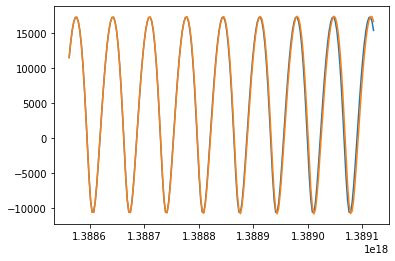

In [8]:
plt.plot(sat_data['epoch'][start_row:start_row+simulation_rows], sat_data[state_cols[0]][start_row:start_row+simulation_rows])
plt.plot(sat_data['epoch'][start_row:start_row+simulation_rows], pred_state[:-1, 0] / 1000)

In [21]:
np.array(pred_state).shape

(201, 6)

#### PCA test

In [9]:
pca = PCA(n_components=2)
coord = pca.fit_transform(sat_data[['x', 'y', 'z']])
speed = pca.transform(sat_data[['Vx', 'Vy', 'Vz']])

In [10]:
utils.smape(pca.inverse_transform(coord), sat_data[['x', 'y', 'z']].to_numpy())

0.002041621717581676